In [1]:
from __future__ import print_function, division
import pandas as pd
from meye import MEImage
from scipy import signal as sg
from scipy.ndimage.filters import maximum_filter
import matplotlib.patches as patches

In [4]:
%pylab inline
plt.rcParams['image.cmap'] = 'gray'

Populating the interactive namespace from numpy and matplotlib


In [79]:
patch_filter_size = 9
k = 0.05
max_filter_size = 9
DEBUG = False
sobel_kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) / 8
sobel_kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]) / 8

In [86]:
def harris_corners(rect,image,DEBUG = False,debug_level = 0):
#init values
    meImg = MEImage.from_file(image)
    rect_mat = meImg.im[rect[2]:rect[3],rect[0]:rect[1]]
    if DEBUG and debug_level == 1:
        print(rect_mat.shape)
        plt.figure()
        print("image rect")
        plt.imshow(rect_mat,cmap='gray',origin='lower')
        
        
#get derivatives
    rect_dx = sg.convolve2d(rect_mat, sobel_kernel_x, "same")
    rect_dy = sg.convolve2d(rect_mat, sobel_kernel_y, "same") 
    
    mat_xx = rect_dx * rect_dx
    mat_yy = rect_dy * rect_dy
    mat_xy = rect_dx * rect_dy
    
    
#mean values
    patch_filter = np.ones((patch_filter_size,patch_filter_size)) / (patch_filter_size**2)
    if DEBUG and debug_level == 1:
        print(patch_filter.shape)
    
    sxx = sg.convolve2d(mat_xx, patch_filter, "same")
    sxy = sg.convolve2d(mat_xy, patch_filter, "same")
    syy = sg.convolve2d(mat_yy, patch_filter, "same")
    if DEBUG and debug_level == 1:
        print(syy.shape)

    if DEBUG and debug_level == 1:
        print("sxx")
        plt.figure()
        plt.imshow(sxx,cmap='gray',origin='lower')
        print("sxy")
        plt.figure()
        plt.imshow(sxy,cmap='gray',origin='lower')
        print("syy")
        plt.figure()
        plt.imshow(syy,cmap='gray',origin='lower')
    
    
#harris detector
    R = np.zeros(rect_mat.shape)
    
    for x in range(rect_mat.shape[0]):
        for y in range(rect_mat.shape[1]):
            H = np.array([[sxx[x][y], sxy[x][y]], [sxy[x][y], syy[x][y]]])
            R[x,y] = np.linalg.det(H) - k*((np.trace(H))**2)
#             R[x][y] = 2*np.linalg.det(H)/(np.trace(H) + 0.01)
   
    if DEBUG and debug_level == 1:
        print("R map")
        plt.figure()
        plt.imshow(R,cmap='gray',origin='lower')
        plt.figure()
        plt.imshow(R[15:70,18:50],cmap='gray',origin='lower')

        
#threshholds maximum etc
    max_R = maximum_filter(R, max_filter_size)
    if DEBUG and debug_level == 1:
        print("R max map")
#         threshold = abs(max_R)
        plt.figure()
        plt.imshow(max_R,cmap='gray',origin='lower')


    #create mask
    mask = np.zeros(rect_mat.shape)
    # mask[(R - max_R)**2 > 1 ] = 1
    mask[(R == max_R)] = 1
#     mask[abs(R - max_R) < 2 and abs(R - max_R) > 1 2 ] = 1
    if DEBUG:
        print("mask")
        plt.figure()
        plt.imshow(mask,cmap='gray',origin='lower')
        print(mask.sum())
    
    if DEBUG:
        plt.figure()
        plt.imshow(rect_mat,cmap='gray',origin='lower')
        for x in range(rect_mat.shape[0]):
            for y in range(rect_mat.shape[1]):
                if mask[x][y]:
#                     plt.scatter(y,x, c='r', s=(R[x-2][y-2]/20))
                    plt.scatter(y,x, c='r', s=2 )
        
    if DEBUG and debug_level == 1:
        plt.figure()
        for x in range(rect_mat.shape[0]):
            for y in range(rect_mat.shape[1]):
                if mask[x][y]:
                    plt.scatter(y,x, c='r', s=2)

    return mask

mask
30.0


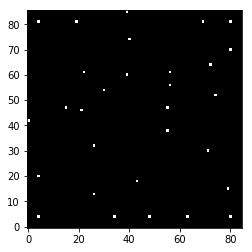

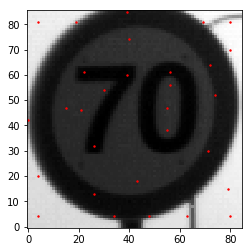

In [87]:
df = pd.read_pickle("store.pickle")
line = df.iloc[0]
rect = line.currRect
img = line.currImage

points = harris_corners(rect,img,True)

mask
24.0


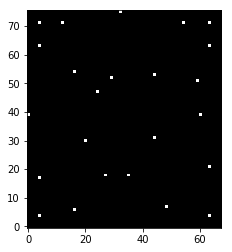

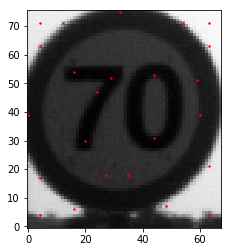

In [88]:
df = pd.read_pickle("store.pickle")
line = df.iloc[0]
rect = line.prevRect
img = line.prevImage

points = harris_corners(rect,img,True)